# Capstone 2: Obesity in America
## Data Wrangling

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Data Collection

Checking that I am in the correct directory and change if need be. 

In [2]:
ls

Capstone2_2.ipynb               Untitled.ipynb
Capstone_BRFSS_Obesity_CSV.csv  data/
DataWrangling_Capstone2.ipynb   figures/
ObesityCapstone2.ipynb          models/
ProjectProposal_Capstone2.pdf


Import my dataset using read_csv and taking a look at the first 5 rows to get an idea of what the dataframe looks like. 

In [3]:
df = pd.read_csv('Capstone_BRFSS_Obesity_CSV.csv')

#### Data Organization

Creating a file structure to store my data, figures and models I create.  

In [4]:
path = 'springboard/Capstone2Project'
print ("The current working directory is %s" % path)

The current working directory is springboard/Capstone2Project


In [5]:
mkdir data

mkdir: data: File exists


In [6]:
mkdir figures

mkdir: figures: File exists


In [7]:
mkdir models

mkdir: models: File exists


#### Data Definition

At this point, I want to gain an understanding of what my data looks like, and what might need to happen to make it cleaner to work with later on. First, I am going to drop some columns I don't need.  
-YearEnd is the same as YearStart, DataSource is the same for all observations, Data Footnote Symbol is unnecessary because we have the footnote itself, and we don't need to know confidence limits. We can also drop geolocation because we have LocationDesc to identify the state. 

In [8]:
df = df.drop(['GeoLocation', 'Sample_Size', 'YearEnd', 'Datasource', 'Data_Value_Unit', 'Data_Value_Footnote_Symbol', 'Data_Value_Type', 'DataValueTypeID', 'Data_Value_Alt', 'Low_Confidence_Limit', 'High_Confidence_Limit '], axis=1)

Next I am going to take a look at null values and data types. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53392 entries, 0 to 53391
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearStart                  53392 non-null  int64  
 1   LocationAbbr               53392 non-null  object 
 2   LocationDesc               53392 non-null  object 
 3   Class                      53392 non-null  object 
 4   Topic                      53392 non-null  object 
 5   Question                   53392 non-null  object 
 6   Data_Value                 48346 non-null  float64
 7   Data_Value_Footnote        5046 non-null   object 
 8   Total                      1907 non-null   object 
 9   Age(years)                 11438 non-null  object 
 10  Education                  7628 non-null   object 
 11  Gender                     3814 non-null   object 
 12  Income                     13349 non-null  object 
 13  Race/Ethnicity             15256 non-null  obj

In [10]:
df.shape

(53392, 22)

In [11]:
df.isnull().mean()

YearStart                    0.000000
LocationAbbr                 0.000000
LocationDesc                 0.000000
Class                        0.000000
Topic                        0.000000
Question                     0.000000
Data_Value                   0.094509
Data_Value_Footnote          0.905491
Total                        0.964283
Age(years)                   0.785773
Education                    0.857132
Gender                       0.928566
Income                       0.749981
Race/Ethnicity               0.714264
ClassID                      0.000000
TopicID                      0.000000
QuestionID                   0.000000
LocationID                   0.000000
StratificationCategory1      0.000000
Stratification1              0.000000
StratificationCategoryId1    0.000000
StratificationID1            0.000000
dtype: float64

A high percentage of Race/Ethnicity, Income, Gender, Education, Age, and Total are null. We can delete these columns because these attributes are categorized neatly for us in the stratification columns. 

9.4% of our Data_Value's are null, which is too high to drop, so we will assess how we should fill them.

In [12]:
df = df.drop(['Race/Ethnicity', 'Income', 'Gender', 'Education', 'Age(years)', 'Total'], axis=1)

In [13]:
df['Data_Value'].describe()

count    48346.000000
mean        31.156681
std         10.247033
min          0.900000
25%         24.100000
50%         30.700000
75%         37.000000
max         77.600000
Name: Data_Value, dtype: float64

In [14]:
df['Data_Value'].isnull().sum()

5046

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb261a00c10>]],
      dtype=object)

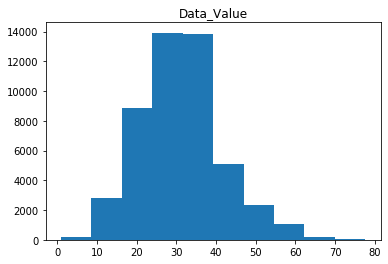

In [15]:
df.hist(column = 'Data_Value', grid = False)

Since the data is skewed slightly left, we will fill the missing values in the Data_Value column with the median. 

In [16]:
median_value = df['Data_Value'].median()
df['Data_Value'] = df['Data_Value'].fillna(median_value)

In [17]:
pd.notnull(df['Data_Value']).value_counts()

True    53392
Name: Data_Value, dtype: int64

We can also drop the column Data_Value_Footnote because it is indicating where there was insufficient data, but we filled those. 

In [18]:
df['Data_Value_Footnote'].unique()

array([nan, 'Data not available because sample size is insufficient.',
       'Data not available because sample size is insufficient.  If data only missing for the confidence interval, the confidence interval was not calculated.'],
      dtype=object)

In [19]:
df = df.drop(['Data_Value_Footnote'], axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53392 entries, 0 to 53391
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearStart                  53392 non-null  int64  
 1   LocationAbbr               53392 non-null  object 
 2   LocationDesc               53392 non-null  object 
 3   Class                      53392 non-null  object 
 4   Topic                      53392 non-null  object 
 5   Question                   53392 non-null  object 
 6   Data_Value                 53392 non-null  float64
 7   ClassID                    53392 non-null  object 
 8   TopicID                    53392 non-null  object 
 9   QuestionID                 53392 non-null  object 
 10  LocationID                 53392 non-null  int64  
 11  StratificationCategory1    53392 non-null  object 
 12  Stratification1            53392 non-null  object 
 13  StratificationCategoryId1  53392 non-null  obj

### Data Cleaning

Lets rename some of our columns so they are more descriptive of what they contain. 

In [21]:
df.rename(columns={'YearStart':'Year', 'LocationDesc':'Location', 'Data_Value':'Percent'}, inplace=True)

Looking closer at the unique values in the data set, it appears there are 55 locations.  We only want to look at the 50 states, so lets identify which are not states and drop those from our data frame. 

In [22]:
df.nunique()

Year                           6
LocationAbbr                  55
Location                      55
Class                          3
Topic                          3
Question                       9
Percent                      669
ClassID                        3
TopicID                        3
QuestionID                     9
LocationID                    55
StratificationCategory1        6
Stratification1               28
StratificationCategoryId1      6
StratificationID1             28
dtype: int64

In [23]:
df['Location'].unique()

array(['Alabama', 'National', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Connecticut', 'Colorado', 'Delaware', 'Florida',
       'District of Columbia', 'Georgia', 'Guam', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'West Virginia', 'Washington', 'Wisconsin', 'Wyoming',
       'Virgin Islands'], dtype=object)

In [24]:
non_states = ['National', 'Guam', 'District of Columbia', 'Puerto Rico', 'Virgin Islands']

In [25]:
df = df[~df['Location'].isin(non_states)]

In [26]:
df['Location'].nunique()

50

In [27]:
df.describe()

,Year,Percent,LocationID
count,50396.000000,50396.000000,50396.000000
mean,2013.249861,31.131205,29.322248
std,1.689440,9.726125,15.622361
min,2011.000000,1.900000,1.000000
25%,2011.000000,24.900000,17.000000
50%,2013.000000,30.700000,30.000000
75%,2015.000000,36.300000,42.000000
max,2016.000000,77.600000,56.000000


In [28]:
pd.to_datetime(df['Year'], format='%Y')

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
53306   2016-01-01
53307   2016-01-01
53308   2016-01-01
53309   2016-01-01
53310   2016-01-01
Name: Year, Length: 50396, dtype: datetime64[ns]